# Converting MISO Tranche 2 into useable data

This notebook exists for documenting the process -- it is not recommended to try re-running the notebook. This is mostly because of the data download step.

A separate script has been included if you wish to download the data from Open Street Map.

The process of doing this was highly manual. The result is an *estimated* dataset with locations and line lengths. Many substations do not currently exist (they would be added by Tranche 2) so I found existing substations that were close-*ish*. Others were misnamed, typos were discovered (e.g., "Lakeﬁeld Junction" was a particularly tricky one) and other errors.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
from us import states
import camelot
import time
from tqdm import tqdm
from pathlib import Path
from glob import glob
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.wkt import loads
import rasterio
import rasterio.plot

### Get spatial lookup table for ReEDS balancing areas

In [2]:
# spatial_lut = pd.read_csv("https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2024/resstock_tmy3_release_2/geographic_information/spatial_tract_lookup_table.csv")
spatial_lut = pd.read_csv("spatial_tract_lookup_table.csv")

In [3]:
spatial_lut.head()

,nhgis_2010_tract_gisjoin,nhgis_2010_county_gisjoin,county_name,state_abbreviation,state_name,census_region,census_division,building_america_climate_zone,iecc_2012_climate_zone,iecc_2012_climate_zone_2a_split,...,census_division_recs,reeds_balancing_areas,generation_emissions_assessment_regions,weather_file_2012,weather_file_2015,weather_file_2016,weather_file_2017,weather_file_2018,weather_file_2019,weather_file_TMY3
0,G0100010020100,G0100010,"AL, Autauga County",AL,Alabama,South,East South Central,Hot-Humid,3A,3A,...,East South Central,90.0,SRSOc,USA_AL_Maxwell.Afb.722265_2012.epw,USA_AL_Maxwell.Afb.722265_2015.epw,USA_AL_Maxwell.Afb.722265_2016.epw,USA_AL_Maxwell.Afb.722265_2017.epw,USA_AL_Maxwell.Afb.722265_2018.epw,USA_AL_Maxwell.Afb.722265_2019.epw,Maxwell_Afb
1,G0100010020200,G0100010,"AL, Autauga County",AL,Alabama,South,East South Central,Hot-Humid,3A,3A,...,East South Central,90.0,SRSOc,USA_AL_Maxwell.Afb.722265_2012.epw,USA_AL_Maxwell.Afb.722265_2015.epw,USA_AL_Maxwell.Afb.722265_2016.epw,USA_AL_Maxwell.Afb.722265_2017.epw,USA_AL_Maxwell.Afb.722265_2018.epw,USA_AL_Maxwell.Afb.722265_2019.epw,Maxwell_Afb
2,G0100010020300,G0100010,"AL, Autauga County",AL,Alabama,South,East South Central,Hot-Humid,3A,3A,...,East South Central,90.0,SRSOc,USA_AL_Maxwell.Afb.722265_2012.epw,USA_AL_Maxwell.Afb.722265_2015.epw,USA_AL_Maxwell.Afb.722265_2016.epw,USA_AL_Maxwell.Afb.722265_2017.epw,USA_AL_Maxwell.Afb.722265_2018.epw,USA_AL_Maxwell.Afb.722265_2019.epw,Maxwell_Afb
3,G0100010020400,G0100010,"AL, Autauga County",AL,Alabama,South,East South Central,Hot-Humid,3A,3A,...,East South Central,90.0,SRSOc,USA_AL_Maxwell.Afb.722265_2012.epw,USA_AL_Maxwell.Afb.722265_2015.epw,USA_AL_Maxwell.Afb.722265_2016.epw,USA_AL_Maxwell.Afb.722265_2017.epw,USA_AL_Maxwell.Afb.722265_2018.epw,USA_AL_Maxwell.Afb.722265_2019.epw,Maxwell_Afb
4,G0100010020500,G0100010,"AL, Autauga County",AL,Alabama,South,East South Central,Hot-Humid,3A,3A,...,East South Central,90.0,SRSOc,USA_AL_Maxwell.Afb.722265_2012.epw,USA_AL_Maxwell.Afb.722265_2015.epw,USA_AL_Maxwell.Afb.722265_2016.epw,USA_AL_Maxwell.Afb.722265_2017.epw,USA_AL_Maxwell.Afb.722265_2018.epw,USA_AL_Maxwell.Afb.722265_2019.epw,Maxwell_Afb


In [4]:
spatial_lut.reeds_balancing_areas.unique().shape

(135,)

Get the Tranche 2 table

In [5]:
tranche_table = camelot.read_pdf("https://cdn.misoenergy.org/MTEP24%20Full%20Report658025.pdf", pages='163')

c:\Users\SDotson\AppData\Local\miniforge3\envs\pypsa-illinois02\Lib\site-packages\camelot\utils.py:740: UserWarning:   (537.96, 539.88228) does not lie in column range (76.07999999105931, 536.76)
  warnings.warn(


In [6]:
tranche_df = tranche_table[0].df.iloc[1:25, 1:4]

In [7]:
tranche_df.columns = ['project_name', 'voltage','isd']

In [8]:
tranche_df

,project_name,voltage,isd
1,Bison - Alexandria,345,2032
2,Maple River - Cuyuna,345,2033
3,Iron Range - Arrowhead,345,2032
4,Big Stone South - Brookings County - Lakeﬁeld ...,765,2034
5,Lakeﬁeld Junction - East Adair,765,2034
6,Lakeﬁeld Junction - Pleasant Valley - North Ro...,765,2034
7,Pleasant Valley - North Rochester - Hampton Co...,345,2032
8,North Rochester - Columbia,765,2034
9,Rocky Run - Werner - North Appleton,345,2032
10,South Fond du Lac - Rockdale - Big Bend - Suga...,345,2033


Transform the project names into starting and ending substations

In [9]:
data = {'r':[],
 'rr':[],
 'voltage':[],
 'isd':[]}
project_name_set = set()
for row in tranche_df.itertuples():
    project = row.project_name
    substation_list = project.split('-')
    # print(substation_list)
    # substation_list = [s.split('&') for s in substation_list]
    # print(substation_list)
    for i, station in enumerate(substation_list[:-1]):
        project_name_set.add(station.strip())
        data['r'].append(station.strip())
        if "&" in substation_list[i+1]:
            split_station = substation_list[i+1].split('&')
            for ss in split_station:
                project_name_set.add(ss.lstrip().rstrip())
            # print(split_station)
            # append the same station again
            data['r'].append(station.strip())
            data['rr'].append(split_station[0].lstrip().rstrip())
            data['rr'].append(split_station[1].lstrip().rstrip())
            # append these twice
            data['voltage'].append(row.voltage)
            data['voltage'].append(row.voltage)
            data['isd'].append(row.isd)
            data['isd'].append(row.isd)
        else:
            project_name_set.add(substation_list[i+1].strip())
            data['rr'].append(substation_list[i+1].strip())
            data['voltage'].append(row.voltage)
            data['isd'].append(row.isd)


In [10]:
project_search = pd.DataFrame({'name':list(project_name_set)})
projects_df = pd.DataFrame(data)

Get the substations from OSMNx

In [11]:
states_of_interest = [
                      'North Dakota',
                      'South Dakota',
                      'Minnesota',
                      'Illinois',
                      'Wisconsin',
                      'Missouri',
                      'Indiana',
                      'Michigan',
                      'Kentucky',
                      'Iowa'
                      ]

In [12]:
download = False

In [13]:
save_path = Path("spatial-data/osmnx_download/").resolve()
save_path.mkdir(parents=True, exist_ok=True)
if download:
    # get counties in each state -- this will yield more data than necessary
    # frames = []
    for state in states_of_interest:
        print(state)
        state_abbr = states.lookup(state).abbr.lower()
        tables = pd.read_html(f'https://en.wikipedia.org/wiki/List_of_counties_in_{state.replace(" ", "_")}')
        # this is super hacky and not guaranteed to always work
        try:
            county_list = tables[1]['County'].to_list()
        except: 
            county_list = tables[0]['County'].to_list()

        start = time.perf_counter()
        pbar = tqdm(county_list, position=0, leave=True)
        for county in pbar:
            pbar.set_description(f"Processing {county}")
            county_name = f"{county}, {state}, United States"
            county_inf = ox.features_from_place(county_name, tags={"power":True})
            county_inf['COUNTY'] = county
            # frames.append(county_inf)
            save_name = county.lower().replace(' county', '')
            save_to = save_path / f"{state_abbr}_{save_name}_infrastructure.csv"
            county_inf.to_csv(str(save_to))
        end = time.perf_counter()
        print(f"Total download took {end-start:.3f} seconds")

Collect downloaded data

In [14]:
osmnx_files = glob(str(save_path/"*.csv"))

In [15]:
frames = []
for file in tqdm(osmnx_files):
    df = pd.read_csv(file, low_memory=False)
    # df = gpd.read_file(file)
    state_abbr = file.split('\\')[-1].split('_')[0].upper()
    df['addr:state'] = state_abbr
    df = df.loc[df.power == 'substation'].dropna(axis=1, how='all')
    frames.append(df)

100%|██████████| 888/888 [00:08<00:00, 107.83it/s]


In [16]:
df = pd.concat(frames, axis=0)

In [17]:
df = df.fillna('-999')

In [18]:
keep_columns = [
 'element',
 'id',
 'geometry',
 'power',
 'voltage',
 'substation',
 'COUNTY',
 'name',
 'addr:state',
]

In [19]:
def fix_voltage(v_string):
    """
    Takes a voltage string, e.g., "120000;69000"
    and returns an int with the highest voltage component.
    This is probably the voltage going into a substation that will be
    stepped down for distribution.
    """
    try:
        v_string = v_string.replace(',',';').replace('?','-999').replace('unknown','-999').replace(':',';')
        split_str = v_string.split(";")
        v_greater = max(split_str)
        if len(v_greater) == 0:
            v_greater = -999
        return int(v_greater)
    except:
        
        return int(v_string)

In [20]:
df['voltage'] = df['voltage'].apply(fix_voltage)

In [21]:
df = df.loc[:, keep_columns]
df['id'] = df['id'].astype(int)

In [22]:
projects_df = projects_df.assign(ba_r = ['-999']*len(projects_df), 
                   ba_rr = ['-999']*len(projects_df), 
                   geometry_r=['-999']*len(projects_df),
                   geometry_rr=['-999']*len(projects_df),
                   ll=['-999']*len(projects_df)
                   )

Search for relevant data! This process sucks and has a lot of manual assignment

In [23]:
project_search = project_search.assign(n_hits=np.zeros(len(project_search)))
for row in project_search.itertuples():
    # sub_df = df.loc[df['name'].str.contains('Lakefield Junction')]
    # display(row.name)
    sub_df = df.loc[df['name'].str.contains(row.name)]
    project_search.at[row.Index, 'n_hits'] = len(sub_df)
    # if len(sub_df) < 1:
    #     display(row.name)

Check which projects have no existing name...

In [24]:
project_search.loc[project_search['n_hits']<1]

,name,n_hits
0,Cuyuna,0.0
5,Woodford County,0.0
7,East Adair,0.0
8,Bugle,0.0
13,Nelson Road,0.0
17,MRPD,0.0
24,Franklin North,0.0
25,Sabine Lake,0.0
29,Radbourn,0.0
31,Lulu,0.0


In [25]:
prefer_state = {'Pleasant Valley':'MN',
                'Columbia':'WI',
                'Maywood':'MO',
                'Bison':'ND',
                'Burr Oak':'IN',
                'Sugar Creek':'WI',
                'Kentucky':'KY',
                'Sioux':'MO',
                'Big Bend':'WI',
                'Hampton':'MN',
                'Fargo':'IL',
                'Collins':"IL",
                'Riverton':'MN',
                'Muskego':'WI',
                'Duff':'IN',
                'Reid EHV':'KY',
                'MRPD':'IL',
                'Sioux':'MO',
                'Bugle':'IL',
                }

prefer_ways = {"Muskego":176515510,
               "Sioux":28609239,
               "Sugar Creek":683026023,
               "Reid EHV":157842577,
               "MRPD":177003601,
               "Bugle":1179586663,
               "Kitty Hawk":176218683
               }
fix_names = {'East Adair':'Arbor Hill',
                     'Lakeﬁeld Junction':'Lakefield Junction',
                     "Sabine Lake":"Latson",
                     "Lulu":"Morocco",
                     "Bluemond":"Bluemound",
                     "Nelson Road":"Nelson\xa0Road",
                     "Woodford County":"Pontiac Midpoint",
                     "Cuyuna": "Riverton",
                     "Franklin North":"Franklin County",
                     "Elm Road":"Oak Creek",
                     "Radbourn":"South Bloomington",
                     "Hampton Corner":"Hampton",
                     "Big Bend":"Arcadian",
                     "Kentucky":"Reid EHV",
                     "Southwest Indiana":"Duff",
                     "Marshalltown":"Marshalltown West"
                     }

In [26]:
project_search = project_search.replace(fix_names)
projects_df = projects_df.replace(fix_names)

Now populate the dataframe with balancing authority and centroid.

In [27]:
project_search = project_search.assign(geometry=['-999']*len(project_search),
                                       ba=[0]*len(project_search))
for row in project_search.itertuples():
    # get the specified substation
    if row.name in prefer_ways.keys():
        sub_df = df.loc[df['id'] == prefer_ways[row.name]]
    else: # project does not have a specified way
        # search by name
        sub_df = df.loc[df['name'].str.contains(row.name)]
        if len(sub_df) == 1:
            # found
            pass
        elif len(sub_df) < 1:
            print(f"{row.name} not found -- need to specify way")
            continue
        else:
            # ambiguous -- more than one hit
            if row.name in prefer_state.keys():
                sub_df = sub_df.loc[sub_df['addr:state'] == prefer_state[row.name]]
            else:
                # prefer highest voltage
                sub_df = sub_df[sub_df['voltage'] == sub_df['voltage'].max()]
                if len(sub_df) > 1:
                    # print(f"{r} is ambiguous -- prefer way to relation")
                    sub_df = sub_df[sub_df['element']=='way']
                if len(sub_df.id.unique()) < len(sub_df):
                    # print(f"{r} is duplicated -- choosing arbitrarily")
                    sub_df = sub_df.iloc[0,:].to_frame().T
                if len(sub_df) > 1:
                    print(f"{r} is ambiguous -- skipping")
                    # project_search.at[row.Index, f'ba_{col}'] = 'AMB'
                    continue
    # display(sub_df)
    state_abbr = sub_df['addr:state'].values[0]
    county = sub_df['COUNTY'].values[0].replace("Saint", 'St.')
    ba = int(spatial_lut.loc[spatial_lut['county_name']==f'{state_abbr}, {county}', 
                                'reeds_balancing_areas'].unique()[0])
    project_search.at[row.Index, f'ba'] = ba

    # get the centroid
    centroid = loads(sub_df.geometry.values[0]).centroid
    project_search.at[row.Index, f'geometry'] = centroid

In [28]:
projects_gdf = gpd.GeoDataFrame(project_search, geometry=project_search['geometry']).drop_duplicates()

In [29]:
# set the CRS
projects_gdf = projects_gdf.set_crs(epsg=4269)
projects_gdf = projects_gdf.to_crs(epsg=5070) # for calculations
projects_gdf = projects_gdf.set_index("name")

In [30]:
for row in projects_df.itertuples():
    
    for r, station in zip(['r','rr'], [row.r, row.rr]):
        projects_df.at[row.Index, f'ba_{r}'] = projects_gdf.at[station, 'ba']
        projects_df.at[row.Index, f'geometry_{r}'] = projects_gdf.to_crs(epsg=4269).at[station, 'geometry']
    
    distance =  projects_gdf.at[row.r, 'geometry'].distance(projects_gdf.at[row.rr, 'geometry'])
    projects_df.at[row.Index, 'll'] = distance


Convert counties to reeds bas

In [32]:
# counties = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/COUNTY/tl_2024_us_county.zip")
counties = gpd.read_file("C:/Users/SDotson/OneDrive - Union of Concerned Scientists\Documents/data-spatial/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")

In [33]:
coi = counties.loc[counties['STATEFP'].isin([states.lookup(s).fips for s in states_of_interest])]

In [34]:
bas = []
for row in coi.itertuples():
    # for TIGER shapefiles
    # ba = int(spatial_lut.loc[spatial_lut['county_name'] == f"{states.lookup(row.STATEFP).abbr}, {row.NAMELSAD}", 'reeds_balancing_areas'].values[0])
    # for Cartographic Boundary Files (CBS)
    ba = int(spatial_lut.loc[spatial_lut['county_name'] == f"{states.lookup(row.STATEFP).abbr}, {row.NAME} County", 'reeds_balancing_areas'].values[0])
    bas.append(ba)

In [35]:
coi['reeds_bas'] = bas

c:\Users\SDotson\AppData\Local\miniforge3\envs\pypsa-illinois02\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [36]:
coi_bas = coi.dissolve('reeds_bas').reset_index(drop=False)

In [37]:
coi_bas['coords'] = coi_bas['geometry'].apply(lambda x: x.representative_point().coords[:])
coi_bas['coords'] = [coords[0] for coords in coi_bas['coords']]

In [38]:
soi = coi.dissolve('STATEFP')

In [39]:
state_shapes = counties.dissolve('STATEFP')

In [45]:
line_colors = {345:'r',
               765:'g'}

In [49]:
contiguous_us = [s.fips for s in states.STATES_CONTIGUOUS]

(-100.5, -78.0)

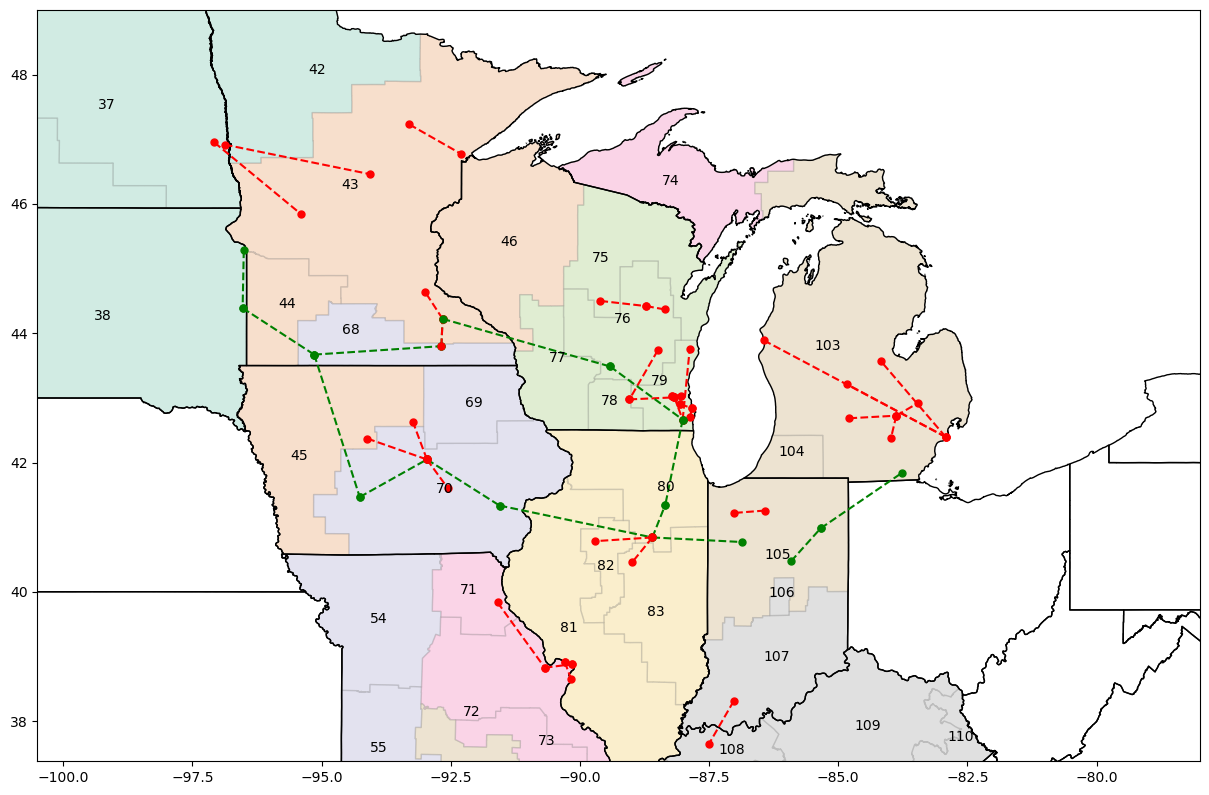

In [52]:
# fig, ax = plt.subplots(figsize=(9,8))
fig, ax = plt.subplots(figsize=(15, 15))
# rasterio.plot.show(raster, ax=ax)
coi_bas.to_crs(4269).plot(ax=ax, column='reeds_bas', categorical=True, cmap='Dark2', ec = 'gray', alpha=0.2)
# soi.plot(ax=ax, fc='None', ec='k')
state_shapes.loc[contiguous_us].plot(ax=ax, fc='None', ec='k')

for idx, row in coi_bas.iterrows():
    plt.annotate(text=row['reeds_bas'], xy=row['coords'], horizontalalignment='center')

for row in projects_df.itertuples():
    x_r = row.geometry_r.x
    y_r = row.geometry_r.y
    x_rr = row.geometry_rr.x
    y_rr = row.geometry_rr.y
    ax.plot([x_r, x_rr], 
            [y_r, y_rr], 
            color=line_colors[int(row.voltage)], 
            markersize=5, 
            marker='o', 
            linestyle='--')
    # ax.plot(x_rr, y_rr)

ax.set_ylim(37.38,49)
ax.set_xlim(-100.5,-78)

In [53]:
raster = rasterio.open('C:/Users/SDotson/OneDrive - Union of Concerned Scientists/Pictures/Screenshots/tranche2.png')

c:\Users\SDotson\AppData\Local\miniforge3\envs\pypsa-illinois02\Lib\site-packages\rasterio\__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


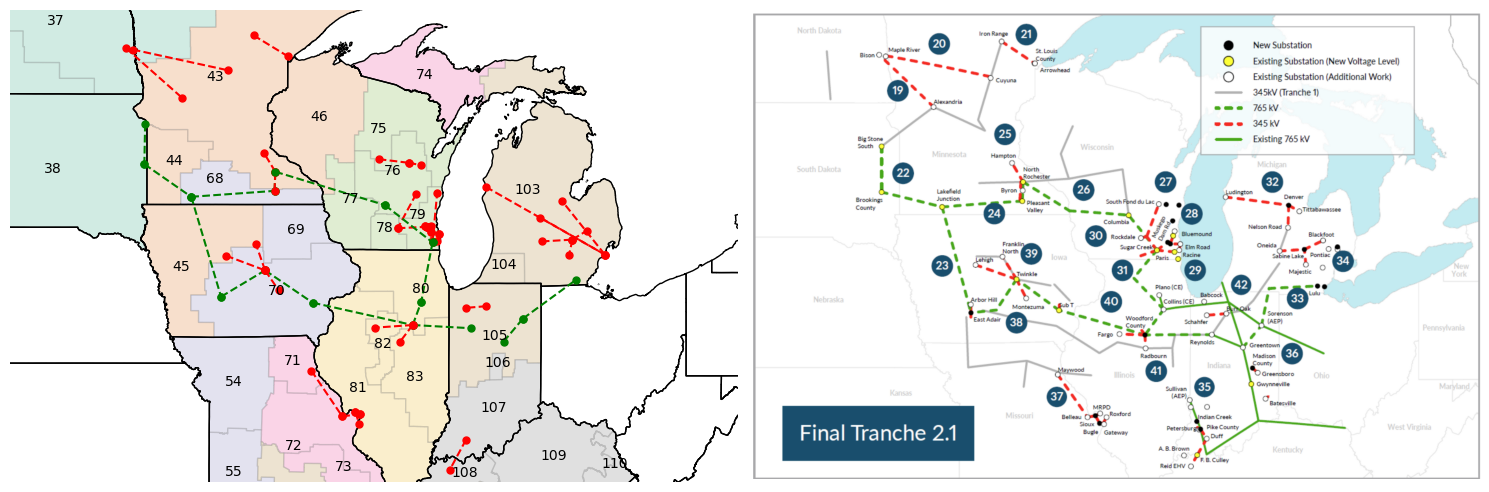

In [59]:
# fig, ax = plt.subplots(figsize=(9,8))
fig, ax = plt.subplots(1,2, figsize=(15, 15))
rasterio.plot.show(raster, ax=ax[1])
coi_bas.plot(ax=ax[0], column='reeds_bas', categorical=True, cmap='Dark2', ec = 'gray', alpha=0.2)
# soi.plot(ax=ax, fc='None', ec='k')
state_shapes.loc[contiguous_us].plot(ax=ax[0], fc='None', ec='k')

for idx, row in coi_bas.iterrows():
    ax[0].annotate(text=row['reeds_bas'], xy=row['coords'], horizontalalignment='center')

for row in projects_df.itertuples():
    x_r = row.geometry_r.x
    y_r = row.geometry_r.y
    x_rr = row.geometry_rr.x
    y_rr = row.geometry_rr.y
    ax[0].plot([x_r, x_rr], [y_r, y_rr], 
               color=line_colors[int(row.voltage)], 
               markersize=5, 
               marker='o',
               linestyle='--')

ax[0].set_ylim(37.38,47.8)
ax[0].set_xlim(-100.5,-79)
ax[0].set_aspect(1.34)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()